In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
class LSTMCNNModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, cnn_filters, output_size):
        super(LSTMCNNModel, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)
        
        # Attention layer (Delete it if you want)
        self.attention_layer = nn.Linear(lstm_hidden_size, 1, bias=False)
        
        # CNN layer
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=2, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)
        
        # Fully connected layer with adjusted input size
        self.fc = nn.Linear(cnn_filters * 64, output_size)  # 
        
            
    def attention(self, lstm_output):
        attn_scores = self.attention_layer(lstm_output)
        attn_weights = torch.softmax(attn_scores, dim=1)
        attn_weights = attn_weights.transpose(1, 2)
        attended_output = torch.bmm(attn_weights, lstm_output)
        return attended_output.squeeze(1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        cnn_input = attn_out.unsqueeze(1)
        cnn_out = self.pool(self.conv1d(cnn_input))
        cnn_out = cnn_out.view(cnn_out.size(0), -1)
        
        # This output shape is 1 for 1 input ! it predicts the next data point ! 
        # Change it, if you want your model to learn how to predict next n datapoint !
        output = self.fc(cnn_out)
        return output


In [5]:
# Data loading cell

file_path = './prices.ods'
data = pd.read_excel(file_path)


# Normalization stuff ! Use them or leave them alone !
print(data['US dollar'].mean() ,data['US dollar'].std() )

# Normal Z score normalazation
global_mean = data['US dollar'].mean()
global_std = data['US dollar'].std()

# Log sacle Z score normalazation
global_log_mean = np.log(global_mean)
global_log_std = np.log(global_std)

# check for data
data


802.0723885297531 595.8718930233364


,Name,US dollar
0,1978-12-29 00:00:00,226.00
1,1979-01-01 00:00:00,226.00
2,1979-01-02 00:00:00,226.80
3,1979-01-03 00:00:00,218.60
4,1979-01-04 00:00:00,223.15
...,...,...
12061,03/31/2025,3150.30
12062,04/01/2025,3146.00
12063,04/02/2025,3166.20
12064,04/03/2025,3121.70


In [6]:
# As you're working with time i recomend you, Use this cell !

data['Name'] = pd.to_datetime(data['Name'])  # Ensure Date is datetime
data = data.sort_values('Name')  # Sort by date if needed


#Extract prices
prices = data['US dollar'].values  # Replace 'GoldPrice' with your column name
prices 

# Remember extract youe own data in this part ! it will be needed at next cell !



array([ 226. ,  226. ,  226.8, ..., 3166.2, 3121.7, 3035.4])

In [7]:
window_size = 7  # Define the size of the input window
X, y = [], []

for i in range(len(prices) - window_size):
    cnx = prices[i:i + window_size]
    # Z score on windows ! I recommend you test your model with and without it
    # cnx = (cnx - cnx.mean()) / cnx.std() 
    X.append(cnx)
    y.append((prices[i + window_size]))  # The next price

X = np.array(X)
y = np.array(y)

# In this cell remember ! my data has only 1 feature !
# As you told me your data has more ! consider that on changing this cell !


In [8]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape y for output layer

# Reshape X to fit LSTM input: (batch_size, sequence_length, input_size)
# Here, sequence_length corresponds to window_size
X_tensor = X_tensor.view(X_tensor.size(0), X_tensor.size(1), 1)  # Add input_size dimension

# Check the shapes
print("X_tensor shape:", X_tensor.shape)  # Should be (num_samples, window_size, 1)
print("y_tensor shape:", y_tensor.shape)  # Should be (num_samples, 1)

# You have 2 options !
# 1 : make every feature of yours in a new dim which means. if you have n features your X shape would be 
#   X_tensor shape: torch.Size([12059, 7, n, 1])

# 2 : concatanate the last 2 dim of option 1 ! if you have n features your X shape would be 
#   X_tensor shape: torch.Size([12059, 7, n])

X_tensor shape: torch.Size([12059, 7, 1])
y_tensor shape: torch.Size([12059, 1])


In [9]:
# Hyperparameters
input_size = 1          # 1 feature (gold price) for my model
lstm_hidden_size = 64   # Hidden size for LSTM
cnn_filters = 128       # Number of filters in the CNN layer
window_size = 7         # Window size
output_size = 1         # Predicting 1 value (next day's price) for my model
batch_size = 32         
lr = 3e-4
weight_decay = 0        # If you had overfit problems use it !


# Model, loss function, optimizer
model = LSTMCNNModel(input_size, lstm_hidden_size, cnn_filters, window_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

model.to(device)
# Training loop
num_epochs = 200


dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.95 * len(dataset))  # 95% for training
val_size = int(0.02 * len(dataset)) # 2% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 5% for testing

# Deterministic slicing
X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]

X_val = X_tensor[train_size:train_size + val_size]
y_val = y_tensor[train_size:train_size + val_size]

X_test = X_tensor[train_size + val_size:]
y_test = y_tensor[train_size + val_size:]

# Creating separate datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Adjust batch size as needed
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# There are two poins to consider !    

# 1:
    # As you saw i did not normalize my Y, that was another trick of mine in this project
    # You may have to change this logic !
    
# 2 :
    # Be aware of this point you might have to cahnge some shape stuff in this cell
    # Based in your data conf in previous cells !


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # This was my idea on goldprice, I suggest you try Z score first ! 
        x_batch = torch.log(x_batch + 1e-8)  # must be all positive

        # x_batch = (x_batch - global_log_mean) / (global_log_std + 1e-8) # batch log z score
        # x_batch = (x_batch - global_mean) / (global_std + 1e-8) # batch normal z score


        optimizer.zero_grad()

        # Forward pass
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # eval your model and check for over/under fit
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # This was my idea on goldprice, I suggest you try Z score first ! 
            x_batch = torch.log(x_batch + 1e-8)  # must be all positive

            # x_batch = (x_batch - global_log_mean) / (global_log_std + 1e-8) # batch log z score
            # x_batch = (x_batch - global_mean) / (global_std + 1e-8) # batch normal z score

            output = model(x_batch)
            val_loss += criterion(output, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}')
    

In [11]:
# This metrics were usefull for me ! may guid you well !

def calculate_metrics(predictions, targets):
    # RMSE
    rmse = torch.sqrt(torch.mean((predictions - targets) ** 2)).item()
    
    # RMAE
    rmae = torch.sqrt(torch.mean(torch.abs(predictions - targets))).item()
    
    # MAPE
    mape = torch.mean(torch.abs((predictions - targets) / targets)) * 100  # In percentage
    mape = mape.item()
    
    return rmse, rmae, mape


In [12]:

# Validation loop for test set

model.eval()  # Set model to evaluation mode
predictions_list, targets_list = [], []

with torch.no_grad():  # Disable gradient calculation for validation
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move to device

        # Watch for normalazation method :)
        x_batch = torch.log(x_batch + 1e-8)  # must be all positive

        # x_batch = (x_batch - global_log_mean) / (global_log_std + 1e-8) # batch log z score
        # x_batch = (x_batch - global_mean) / (global_std + 1e-8) # batch normal z score
        
        # Make predictions
        predictions = model(x_batch)
        predictions = torch.exp(predictions)
        
        # Store predictions and targets for metrics calculation
        predictions_list.append(predictions)
        targets_list.append(y_batch)

# Concatenate all predictions and targets
all_predictions = torch.cat(predictions_list, dim=0)
all_targets = torch.cat(targets_list, dim=0)


all_targets = all_targets.to('cpu')
all_predictions = all_predictions.to('cpu')

# This part is There for a reason. You might normalize the Y to ! so model learns the normalized Y!
# You have to take it back if you used log use : torch.exp or np.exp
# But if you used z-score use a code similar to beloow codes ! 

# all_targets = (all_targets * std_price) + mean_price
# all_predictions = (all_predictions * std_price) + mean_price


# Calculate metrics
rmse, rmae, mape = calculate_metrics(all_predictions, all_targets)

# Calculate R^2 score
r2 = r2_score(all_targets.to('cpu'), all_predictions.to('cpu'))

print(f"R^2 Score: {r2:.4f}")
print(f"TEST RMSE: {rmse:.4f}")
print(f"TEST RMAE: {rmae:.4f}")
print(f"TEST MAPE: {mape:.2f}%")


R^2 Score: 0.9839
TEST RMSE: 39.7411
TEST RMAE: 5.5616
TEST MAPE: 1.24%


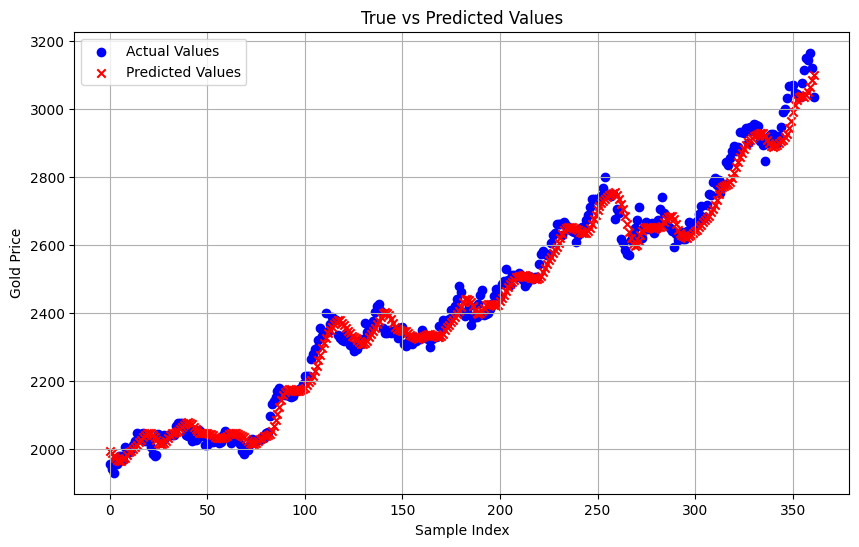

In [13]:
# This ell is for you to visualize your test results !

all_targets = all_targets.to('cpu')
all_predictions = all_predictions.to('cpu')


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_targets)), all_targets, color='blue', label='Actual Values', marker='o')
plt.scatter(range(len(all_predictions)), all_predictions, color='red', label='Predicted Values', marker='x')
# plt.plot(all_targets.to('cpu'), color='blue', linestyle='--', alpha=0.5)  # Optional: Connect the actual values with a line
# plt.plot(all_predictions.to('cpu'), color='red', linestyle='--', alpha=0.5)  # Optional: Connect the predicted values with a line

# Add titles and labels
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Dont forget to save your model !

# torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Load if if you want :)

# model.load_state_dict(torch.load('model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
# Dear Hooman may this code guid you well but if you need any help call me !

# The ideas you may want to be implemented in this code
#   early stopping
#   paralell h_param tuning
#   etc ...